# *Advanced example* from the docs: gaussian ring

In [1]:
# Configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
try:
    from cobaya.run import run
except ImportError:
    sys.path.insert(0,'../../cobaya')
    from cobaya.run import run

### Defining the *Gaussian ring* likelihood and priors for its parameters

In [2]:
import numpy as np
from scipy import stats

def gauss_ring_logp(x, y):
    return stats.norm.logpdf(np.sqrt(x**2+y**2), loc=1, scale=0.2)

info = {"likelihood": {"ring": gauss_ring_logp}}

In [3]:

info["params"] = dict([
    ["x", {"prior": {"min": -2, "max": 2}, "ref": 1, "proposal": 0.2}],
    ["y", {"prior": {"min": -2, "max": 2}, "ref": 0, "proposal": 0.2}]])

### Defining *dynamical* derived parameters: radius and angle

In [4]:
r = "lambda x,y: np.sqrt(x**2+y**2)"
theta = "lambda x,y: np.arctan(y/x)"

info["params"]["r"] = {"derived": r}
info["params"]["theta"] = {"derived": theta, "latex": r"\theta", "min": -np.pi/2, "max": np.pi/2}

### Sample and plot!

In [5]:
# Very non-gaussian shape: increase the default convergence criterion
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.002}}

from cobaya.run import run
updated_info, products = run(info)

[ring] Initialized external likelihood.
[model] Setting measured speeds (per sec): {ring: 12700.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (was 2).
[mcmc] Initial point: x:1.00001, y:0
[mcmc] Sampling! (NB: no accepted step will be saved until 40 burn-in samples have been obtained)
[mcmc] Progress at [2020-01-28 16:07:35] : 1 steps taken -- still burning in, 41 accepted steps left.
[mcmc] Finished burn-in phase: discarded 40 accepted steps.
[mcmc] Checkpoint: 80 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.491
[mcmc] Convergence of means: R-1 = 1.823938 after 80 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 160 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.519
[mcmc] Convergence of means: R-1 = 0.501451 after 160 accepted steps
[mcmc] Updated covariance

[mcmc] Checkpoint: 2480 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.206
[mcmc] Convergence of means: R-1 = 0.004048 after 2480 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 2560 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.205
[mcmc] Convergence of means: R-1 = 0.002063 after 2560 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 2640 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.206
[mcmc] Convergence of means: R-1 = 0.009445 after 2640 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 2720 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.206
[mcmc] Convergence of means: R-1 = 0.014153 after 2720 accepted steps
[mcmc] Updated cov

[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 5040 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.203
[mcmc] Convergence of means: R-1 = 0.006639 after 5040 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 5120 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.203
[mcmc] Convergence of means: R-1 = 0.006312 after 5120 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 5200 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.203
[mcmc] Convergence of means: R-1 = 0.008642 after 5200 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 5280 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.203
[mcmc] Convergence of means: R-1 = 0.0

[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 7600 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.198
[mcmc] Convergence of means: R-1 = 0.003677 after 7600 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 7680 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.198
[mcmc] Convergence of means: R-1 = 0.003610 after 7680 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 7760 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.198
[mcmc] Convergence of means: R-1 = 0.004085 after 7760 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 7840 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.197
[mcmc] Convergence of means: R-1 = 0.0

[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 10160 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.198
[mcmc] Convergence of means: R-1 = 0.003966 after 10160 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 10240 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.198
[mcmc] Convergence of means: R-1 = 0.003919 after 10240 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 10320 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.198
[mcmc] Convergence of means: R-1 = 0.004286 after 10320 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 10400 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.198
[mcmc] Convergence of means: R-

[mcmc] Acceptance rate: 0.196
[mcmc] Convergence of means: R-1 = 0.001611 after 12640 accepted steps
[mcmc] Convergence of bounds: R-1 = 0.079577 after 12640 accepted steps
[mcmc] The run has converged!
[mcmc] Sampling complete after 12640 accepted steps.


[root] *WARNING* auto bandwidth for theta very small or failed (h=0.0006561092818690041,N_eff=5669.3515812475). Using fallback (h=0.07021588970468426)


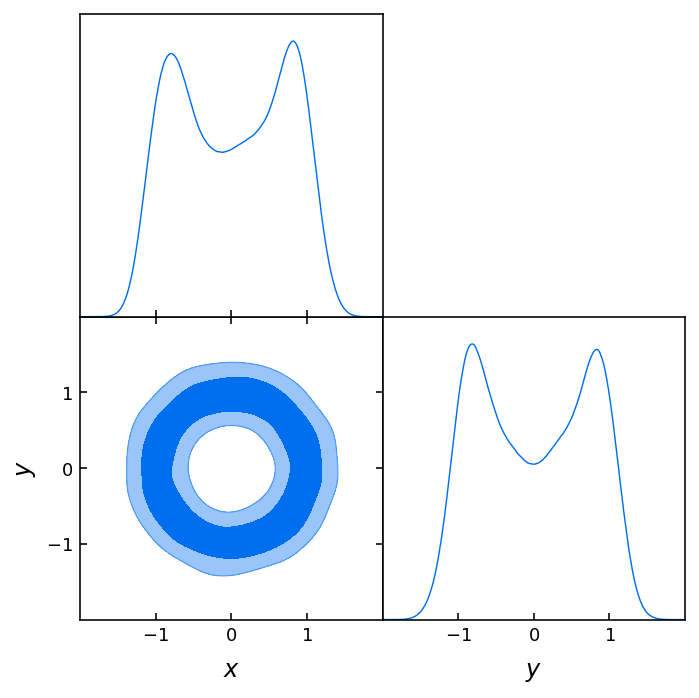

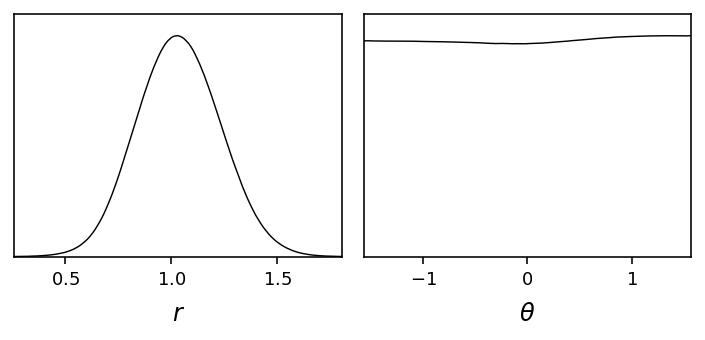

In [6]:
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gdsamples = MCSamplesFromCobaya(updated_info, products["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["x", "y"], filled=True)
gdplot.export("example_adv_ring.png")
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.plots_1d(gdsamples, ["r", "theta"], nx=2)
gdplot.export("example_adv_r_theta.png")

### Imposing $x>y$

In [15]:
info["prior"] = {"xGTy": lambda x,y: 1 if x>y else -np.inf}

from cobaya.run import run
updated_info_xGTy, products_xGTy = run(info)

[prior] *WARNING* External prior 'xGTy' loaded. Mind that it might not be normalized!
[ring] Initialized external likelihood.
[model] Setting measured speeds (per sec): {ring: 10100.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (was 2).
[mcmc] Initial point: x:1.00001, y:0
[mcmc] Sampling! (NB: no accepted step will be saved until 40 burn-in samples have been obtained)
[mcmc] Progress at [2020-01-28 16:08:55] : 1 steps taken -- still burning in, 40 accepted steps left.
[mcmc] Finished burn-in phase: discarded 40 accepted steps.
[mcmc] Checkpoint: 80 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.408
[mcmc] Convergence of means: R-1 = 0.146894 after 80 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 160 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.387
[mcmc] C

[mcmc] Convergence of means: R-1 = 0.009682 after 2400 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 2480 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.224
[mcmc] Convergence of means: R-1 = 0.011424 after 2480 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 2560 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.224
[mcmc] Convergence of means: R-1 = 0.022487 after 2560 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 2640 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.224
[mcmc] Convergence of means: R-1 = 0.004406 after 2640 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 2720 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covma

[mcmc] Acceptance rate: 0.216
[mcmc] Convergence of means: R-1 = 0.003438 after 4960 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 5040 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.215
[mcmc] Convergence of means: R-1 = 0.003580 after 5040 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 5120 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.215
[mcmc] Convergence of means: R-1 = 0.003343 after 5120 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 5200 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.215
[mcmc] Convergence of means: R-1 = 0.003387 after 5200 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 5280 samples accepted.
[mcmc] Ready to check convergence 

[mcmc] Acceptance rate: 0.211
[mcmc] Convergence of means: R-1 = 0.003844 after 7520 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 7600 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.211
[mcmc] Convergence of means: R-1 = 0.003174 after 7600 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 7680 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.211
[mcmc] Convergence of means: R-1 = 0.002338 after 7680 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 7760 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.211
[mcmc] Convergence of means: R-1 = 0.001645 after 7760 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 7840 samples accepted.
[mcmc] Ready to check convergence 

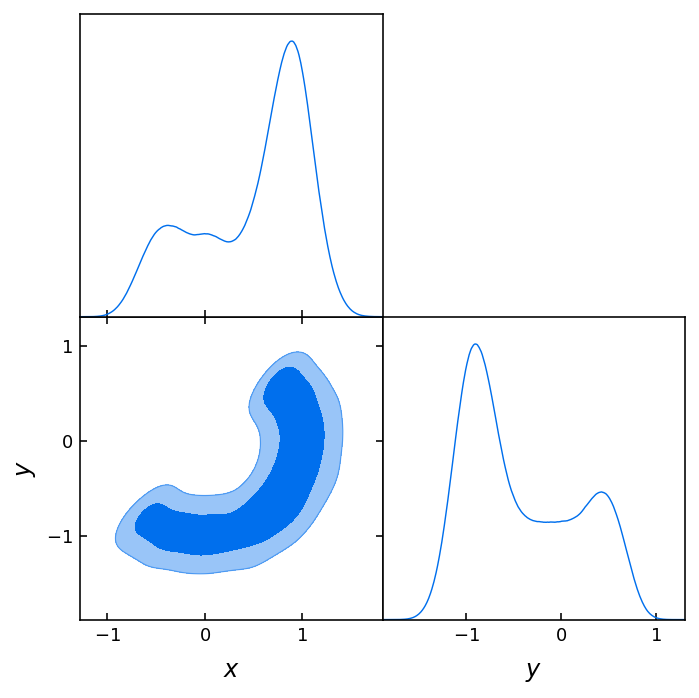

In [16]:
gdsamples_xGTy = MCSamplesFromCobaya(
    updated_info_xGTy, products_xGTy["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples_xGTy, ["x", "y"], filled=True)
gdplot.export("example_adv_half.png")

## Alternative: $r$ and $\theta$ as derived parameters of the likelihood

In [9]:
# List available derived paramters in the default value of the `derived` keyword
def gauss_ring_logp_with_derived(x, y, _derived=["r", "theta"]):
    r = np.sqrt(x**2+y**2)
    # Assuming `derived` is passed at runtime as a dictionary to be filled
    _derived["r"] = r
    _derived["theta"] = np.arctan(y/x)
    return stats.norm.logpdf(r, loc=1, scale=0.2)

# Now we don't need to *define* (but do need to *mention*) r or theta if we want their values output
info_alt = {"likelihood": {"ring": gauss_ring_logp_with_derived}}
info_alt["params"] = dict([
    ["x", {"prior": {"min": -2, "max": 2}, "ref": 1, "proposal": 0.2}],
    ["y", {"prior": {"min": -2, "max": 2}, "ref": 0, "proposal": 0.2}],
    ["r", None],
    ["theta", {"latex": r"\theta"}]])
info_alt["prior"] = {"xGTy": lambda x,y: np.log(x>y)}

In [10]:
info_alt["sampler"] = info["sampler"]
updated_info_alt, products_alt = run(info_alt)

[prior] *WARNING* External prior 'xGTy' loaded. Mind that it might not be normalized!
[ring] Initialized external likelihood.
[model] Setting measured speeds (per sec): {ring: 10700.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (was 2).
[mcmc] Initial point: x:1.00001, y:0
[mcmc] Sampling! (NB: no accepted step will be saved until 40 burn-in samples have been obtained)
[mcmc] Progress at [2020-01-28 16:08:01] : 1 steps taken -- still burning in, 41 accepted steps left.
[mcmc] Finished burn-in phase: discarded 40 accepted steps.
[mcmc] Checkpoint: 80 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.415
[mcmc] Convergence of means: R-1 = 1.210771 after 80 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 160 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.386
[mcmc] C

C:\WorkProgs\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


[mcmc] Checkpoint: 240 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.320
[mcmc] Convergence of means: R-1 = 0.202997 after 240 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 320 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.294
[mcmc] Convergence of means: R-1 = 0.132985 after 320 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 400 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.282
[mcmc] Convergence of means: R-1 = 0.122264 after 400 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 480 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.282
[mcmc] Convergence of means: R-1 = 0.089604 after 480 accepted steps
[mcmc] Updated covariance 

[mcmc] Checkpoint: 2800 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.225
[mcmc] Convergence of means: R-1 = 0.002074 after 2800 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 2880 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.224
[mcmc] Convergence of means: R-1 = 0.001642 after 2880 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 2960 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.223
[mcmc] Convergence of means: R-1 = 0.001269 after 2960 accepted steps
[mcmc] Convergence of bounds: R-1 = 0.075109 after 2960 accepted steps
[mcmc] The run has converged!
[mcmc] Sampling complete after 2960 accepted steps.


[root] *WARNING* outlier fraction 0.002702702702702703 


(2, 1)

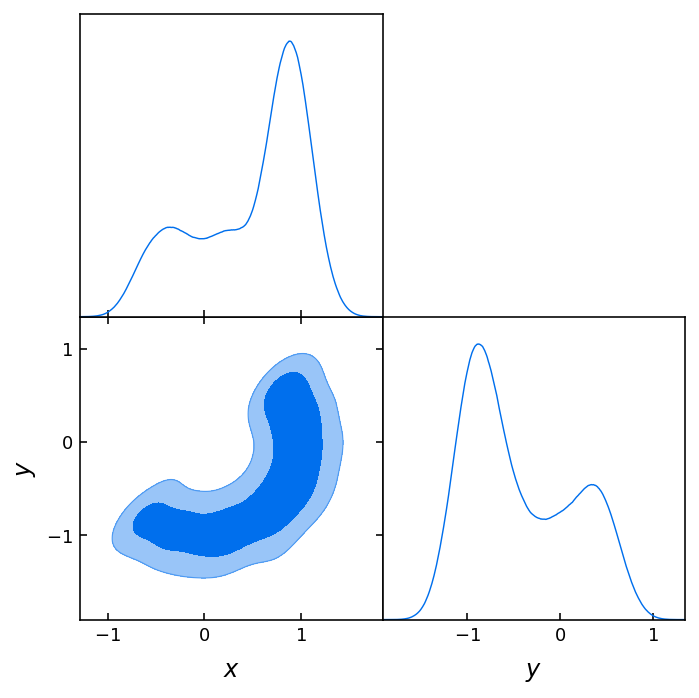

<Figure size 360x270 with 0 Axes>

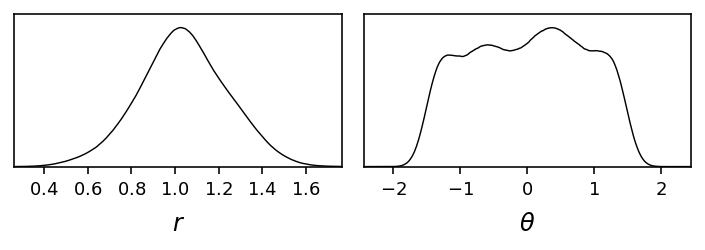

In [11]:
gdsamples_alt = MCSamplesFromCobaya(
    updated_info_alt, products_alt["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples_alt, ["x", "y"], filled=True)
gdplot = gdplt.get_single_plotter(width_inch=5)
gdplot.plots_1d(gdsamples_alt, ["r", "theta"], nx=2)

## Even better: sampling on $r$ and $\theta$ instead

In [12]:
from copy import deepcopy
info_rtheta = deepcopy(info)
info_rtheta["params"] = dict([
    ["r", {"prior": {"min": 0, "max": 2}, "ref": 1,
           "proposal": 0.5, "drop": True}],
    ["theta", {"prior": {"min": -0.75*np.pi, "max": np.pi/4}, "ref": 0,
               "proposal": 0.5, "latex": r"\theta", "drop": True}],
    ["x", "lambda r,theta: r*np.cos(theta)"],
    ["y", "lambda r,theta: r*np.sin(theta)"]])
# The x>y condition is already incorporated in the prior of theta
info_rtheta["prior"].pop("xGTy")

<function __main__.<lambda>(x, y)>

In [13]:
updated_info_rtheta, products_rtheta = run(info_rtheta)

[ring] Initialized external likelihood.
[model] Setting measured speeds (per sec): {ring: 11100.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (was 2).
[mcmc] Initial point: r:1.00001, theta:0
[mcmc] Sampling! (NB: no accepted step will be saved until 40 burn-in samples have been obtained)
[mcmc] Progress at [2020-01-28 16:08:08] : 1 steps taken -- still burning in, 41 accepted steps left.
[mcmc] Finished burn-in phase: discarded 40 accepted steps.
[mcmc] Checkpoint: 80 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.170
[mcmc] Convergence of means: R-1 = 0.613500 after 80 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 160 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.221
[mcmc] Convergence of means: R-1 = 0.288921 after 160 accepted steps
[mcmc] Updated covari

[mcmc] Checkpoint: 2480 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.287
[mcmc] Convergence of means: R-1 = 0.023715 after 2480 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 2560 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.285
[mcmc] Convergence of means: R-1 = 0.013240 after 2560 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 2640 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.286
[mcmc] Convergence of means: R-1 = 0.013085 after 2640 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 2720 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.286
[mcmc] Convergence of means: R-1 = 0.012141 after 2720 accepted steps
[mcmc] Updated cov

[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 5040 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.283
[mcmc] Convergence of means: R-1 = 0.015646 after 5040 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 5120 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.282
[mcmc] Convergence of means: R-1 = 0.013089 after 5120 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 5200 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.282
[mcmc] Convergence of means: R-1 = 0.012897 after 5200 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 5280 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.282
[mcmc] Convergence of means: R-1 = 0.0

[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 7600 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.283
[mcmc] Convergence of means: R-1 = 0.008736 after 7600 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 7680 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.283
[mcmc] Convergence of means: R-1 = 0.009099 after 7680 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 7760 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.283
[mcmc] Convergence of means: R-1 = 0.009901 after 7760 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 7840 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.283
[mcmc] Convergence of means: R-1 = 0.0

[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 10160 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.285
[mcmc] Convergence of means: R-1 = 0.002513 after 10160 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 10240 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.285
[mcmc] Convergence of means: R-1 = 0.002184 after 10240 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 10320 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.285
[mcmc] Convergence of means: R-1 = 0.002365 after 10320 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 10400 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Acceptance rate: 0.285
[mcmc] Convergence of means: R-

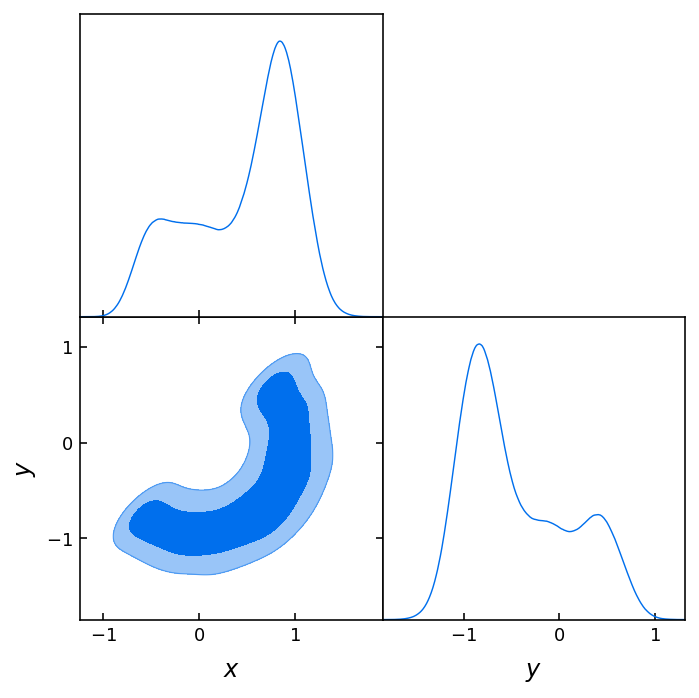

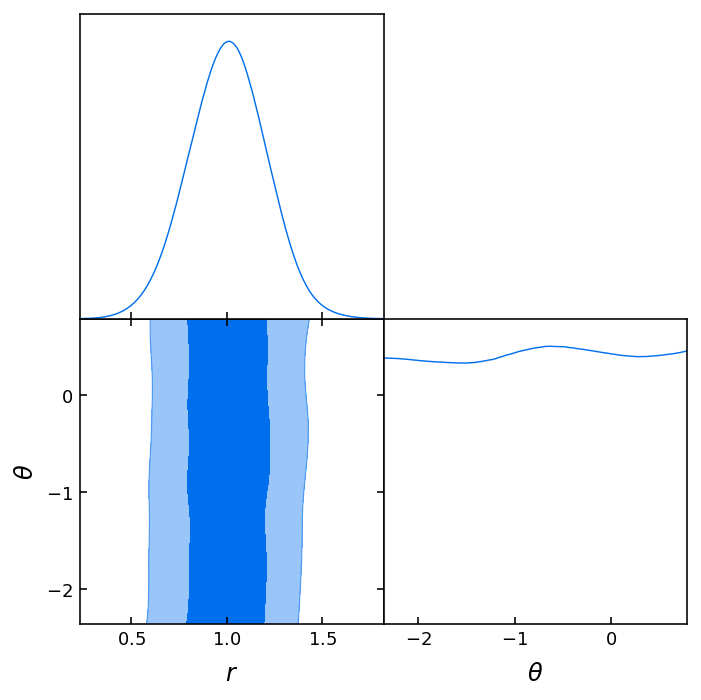

In [14]:
gdsamples_rtheta = MCSamplesFromCobaya(
    updated_info_rtheta, products_rtheta["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples_rtheta, ["x", "y"], filled=True)
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples_rtheta, ["r", "theta"], filled=True)